# Trenowanie metodą SVM i sieciami MLP

Projekt polega na porównaniu dwóch modeli uczenia maszynowego:
1. SVM trenowany dla **pełnych danych** i **wszystkich cech**.
1. Kilku sieci MLP składających się z **tej samej liczby neuronów** lecz różnej liczby warstw.

## 1. Zbióry danych treningowych

Przeprowadzenie porównania klasyfikatorów wykonamy na dwóch zbiorach: **MNIST** oraz **FMNIST**. Oba zbiory dostępne są między innymi w bibliotece *tensorflow* oraz *sklearn.datasets*.

### MNIST

8


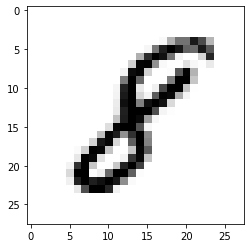

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
image_index = 7777 # You may select anything up to 70,000
print(y_train[image_index])
plt.imshow(x_train[image_index], cmap='Greys')

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

### FMNIST

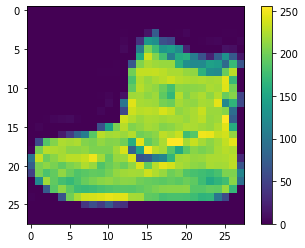

In [5]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
plt.figure()
plt.imshow(train_images[0])

plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

## 2. Trenowanie i porównanie klasyfikatorów

### SVM

In [7]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

Ze względu **bardzo długi** czas uczenia metodą SVM na pełnym zbiorze - 70 000 obrazków (zbiory MNIST oraz FMNIST mają taką samą wielkość) - zdecydowaliśmy się na zmniejszenie zbioru o połowę - do 35 000. Taka decyzja wynikała z niemożliwości wykonania obliczeń dla pełnego zbioru. Gdy uruchomiłem uczenie SVM, po upływie 6h nadal nie uzysałem rezultatu. Złożoność czasowa dla SVM rośnie kwadratowo - przypuszczam, że na dokonanie pomiarów dla pełnego zbioru 70 000 elemntów i 10 cech potrzebowałbym więcej niż 12h obliczeń.

In [8]:
partmnist_data = mnist.data[0:10000]
partmnist_target = mnist.target[0:10000]

### Trenowanie klasyfikatora ze zbiorem testowym wynoszącym 25%

In [9]:
test_size = 0.1
x_mnist, y_mnist = partmnist_data, partmnist_target

x_train, x_test, y_train, y_test = train_test_split(x_mnist, y_mnist, test_size=test_size)

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_mnist = scaler.transform(x_mnist)

linear_svc = OneVsRestClassifier(svm.SVC(kernel="linear", C=0.1, probability=True)).fit(x_train, y_train)
y_predicted = linear_svc.predict(x_test)
y_predicted_proba = linear_svc.predict_proba(x_test)    

### Krzywa ROC klasyfikatora

In [10]:
import scikitplot as skplt
import matplotlib.pyplot as plt

def roc(y_test, y_predicted_proba):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 10
    skplt.metrics.plot_roc(y_test, y_predicted_proba)
    plt.show()

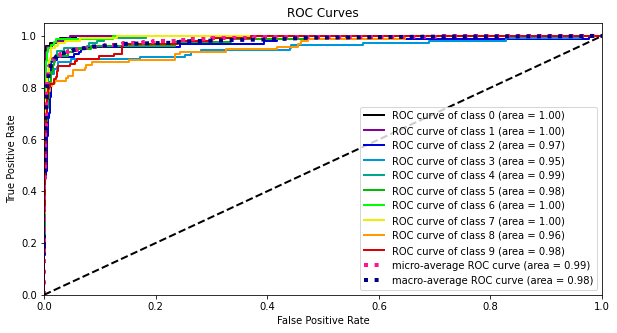

In [11]:
roc(y_test, y_predicted_proba)

### Krzywa Precision-Recall klasyfikatora

In [12]:
def precision_recall(y_test, y_predicted_proba):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 10
    skplt.metrics.plot_precision_recall(y_test, y_predicted_proba)
    plt.show()

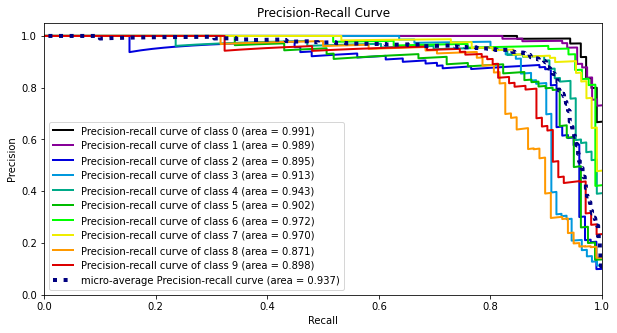

In [13]:
precision_recall(y_test, y_predicted_proba)

### Wyniki jakości klasyfikatora

In [14]:
def show_res(x_test, y_test, y_predicted, y_predicted_proba):
    print("Accuracy score:", metrics.accuracy_score(y_test, y_predicted))
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - -")
    print("Loss:", metrics.hinge_loss(y_test, y_predicted_proba))
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - -")
    print("Średnia ważona Precision-Recall dla każdej kategorii")
    f1_score = metrics.f1_score(y_test, y_predicted, average = None)
    for i, res in enumerate(f1_score):
        print("klasa",  i, ":", res)

In [15]:
show_res(x_test, y_test, y_predicted, y_predicted_proba)

Accuracy score: 0.892
- - - - - - - - - - - - - - - - - - - - - - - - - - -
Loss: 0.3976735753110066
- - - - - - - - - - - - - - - - - - - - - - - - - - -
Średnia ważona Precision-Recall dla każdej kategorii
klasa 0 : 0.9569377990430622
klasa 1 : 0.9375
klasa 2 : 0.8799999999999999
klasa 3 : 0.8815165876777251
klasa 4 : 0.8755760368663594
klasa 5 : 0.8553459119496856
klasa 6 : 0.9349112426035502
klasa 7 : 0.9090909090909091
klasa 8 : 0.8404255319148936
klasa 9 : 0.8374384236453202


Ocena jakości klasyfikatorów w zależności od **ilości przykładów uczącyc** - parametr *test_size*

In [ ]:
def compare_SVM(test_size):
    x_mnist, y_mnist = partmnist_data, partmnist_target
    x_train, x_test, y_train, y_test = train_test_split(x_mnist, y_mnist, test_size=test_size)
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    x_mnist = scaler.transform(x_mnist)
    linear_svc = OneVsRestClassifier(svm.SVC(kernel="linear", C=0.1, probability=True)).fit(x_train, y_train)
    print("=====================================================")
    print("Test_size:", test_size)
    print("=====================================================")
    show_res(x_test, y_test)
    
test_size_sample = [0.25, 0.4, 0.55, 0.7]
for test_size in test_size_sample:
    compare_SVM(test_size)

### MLP

In [16]:
import keras
from keras.datasets import mnist, fashion_mnist
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

Using TensorFlow backend.


In [17]:
def create_dense(layer_sizes, num_classes=10):
    model = Sequential()
    model.add(Dense(layer_sizes[0], activation='sigmoid', input_shape=(image_size,)))

    for s in layer_sizes[1:]:
        model.add(Dense(units = s, activation = 'sigmoid'))

    model.add(Dense(units=num_classes, activation='softmax'))

    return model


def evaluate(model,x_train, y_train, x_test, y_test, y_test_flatten, epochs=3, batch_size=16):
#     model.summary()
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.1, verbose=False, validation_data = (x_test, y_test))
    y_pred_keras = model.predict(x_test)
    print(f'Test loss: {history.history["loss"][-1]}')
    print(f'Test accuracy: {history.history["accuracy"][-1]}')
    draw_curves(history)
    precision_recall(y_test_flatten, y_pred_keras)
    roc(y_test_flatten, y_pred_keras)

In [18]:
def draw_curves(history, key1='accuracy', ylim1=(0.0, 1.00), 
                key2='loss', ylim2=(0.0, 1.0)):
    plt.figure(figsize=(12,4))
     
    plt.subplot(1, 2, 1)
    plt.plot(history.history[key1], "r--")
    plt.plot(history.history['val_' + key1], "g--")
    plt.ylabel(key1)
    plt.xlabel('Epoch')
    plt.ylim(ylim1)
    plt.legend(['train', 'test'], loc='best')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history[key2], "r--")
    plt.plot(history.history['val_' + key2], "g--")
    plt.ylabel(key2)
    plt.xlabel('Epoch')
    plt.ylim(ylim2)
    plt.legend(['train', 'test'], loc='best')
     
    plt.show()

In [19]:
def diff_size(x, y, epochs = 10):
    for train_size in [0.25, 0.4, 0.55, 0.7]:
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size)
        num_classes = 10
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)
        y_test_flatten = np.argmax(y_test, axis=1)

        print("\n==============================================================================================")
        print(f'P: {train_size:.3}')

        for neuron in [150, 1000]:    
            for layers in [1, 2, 5,10]:
                print(f'L: {layers} N: {neuron}')
                model = create_dense([neuron] * layers)
                evaluate(model, x_train, y_train, x_test, y_test, y_test_flatten, batch_size=64, epochs=epochs)  

In [20]:
def epochs(x, y):
    train_size = 0.7
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size)
    num_classes = 10
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    y_test_flatten = np.argmax(y_test, axis=1)

    for epoch in [5, 40, 100]:
        print("\n==============================================================================================")
        print(f'E: {epoch}')

        for neuron in [150, 1000]:    
            for layers in [1, 2, 5,10]:
                print(f'L: {layers} N: {neuron}')
                model = create_dense([neuron] * layers)
                evaluate(model, x_train, y_train, x_test, y_test, y_test_flatten, batch_size=64, epochs=epoch)  

# MNIST


P: 0.25
L: 1 N: 150
Test loss: 0.10330441726275853
Test accuracy: 0.975942850112915


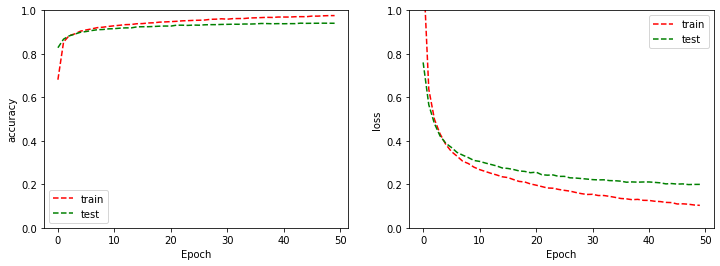

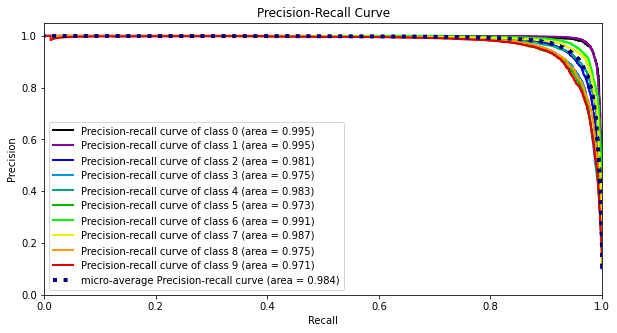

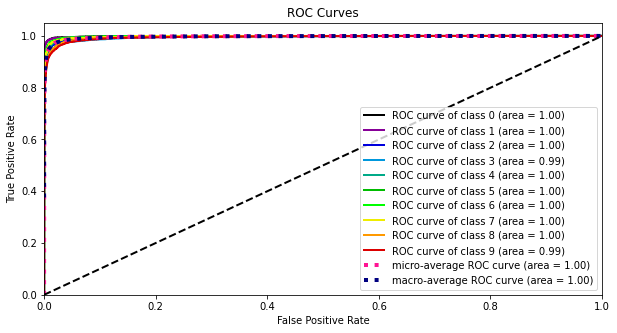

L: 2 N: 150
Test loss: 0.14695661492347717
Test accuracy: 0.9629142880439758


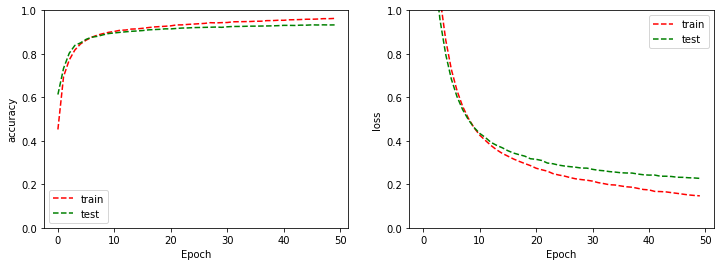

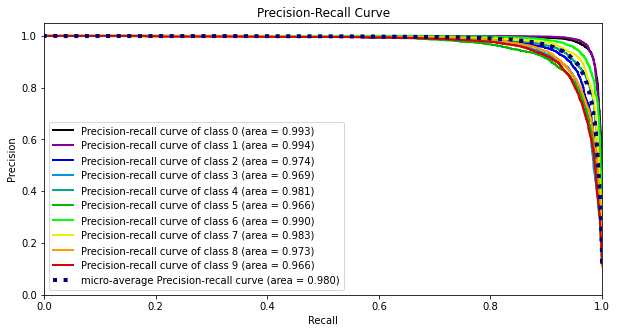

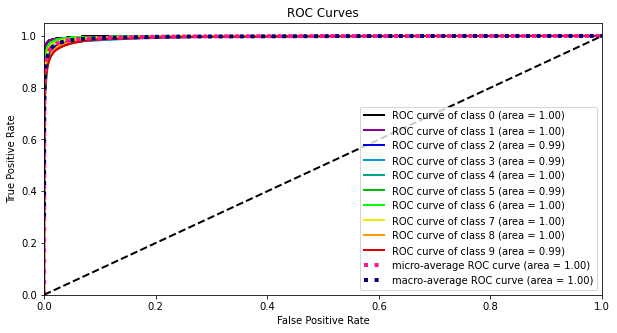

L: 5 N: 150
Test loss: 2.283970165034703
Test accuracy: 0.168857142329216


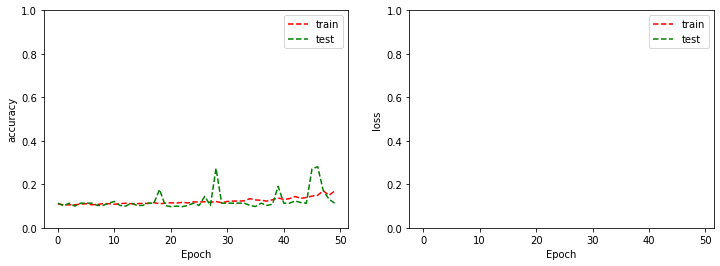

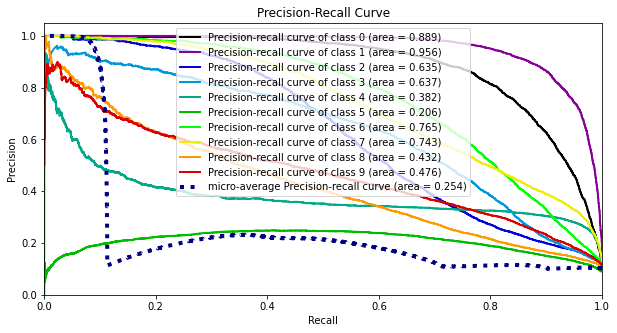

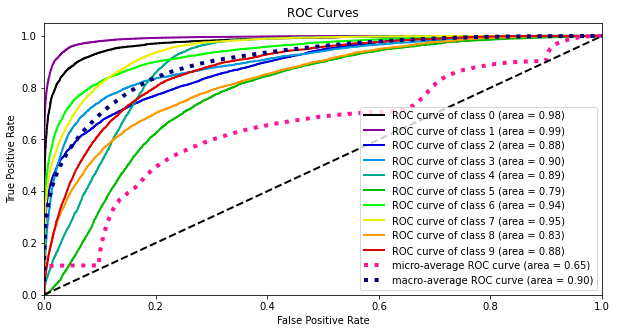

L: 10 N: 150
Test loss: 2.303248322568621
Test accuracy: 0.10857142508029938


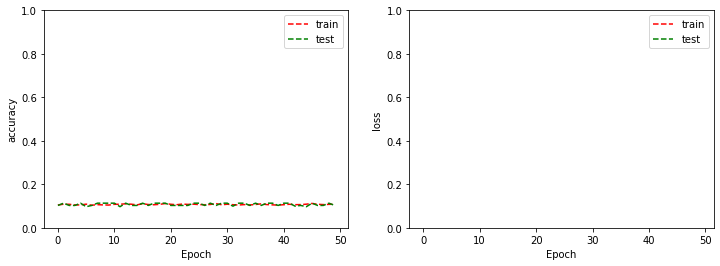

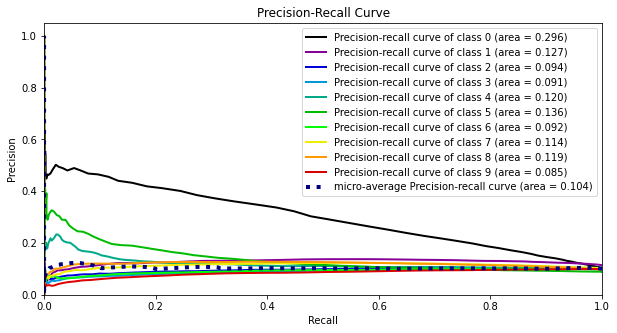

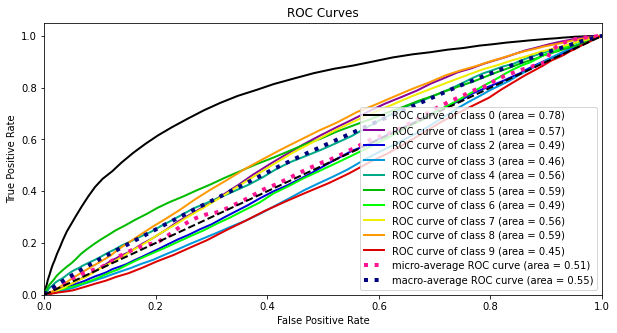

L: 1 N: 1000
Test loss: 0.019002599753226553
Test accuracy: 0.9978285431861877


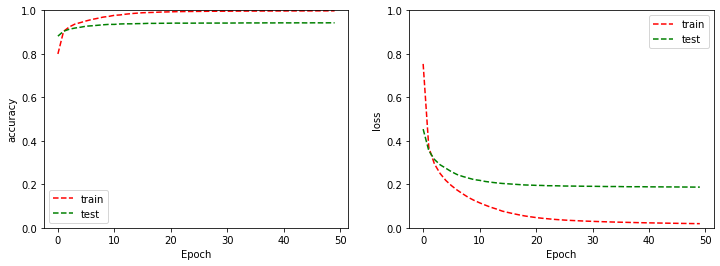

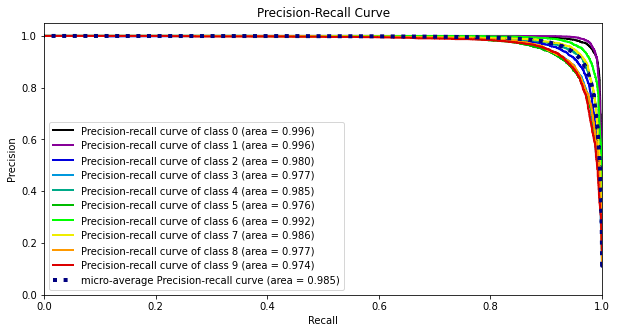

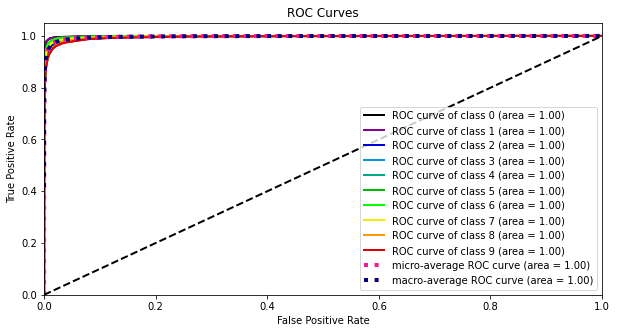

L: 2 N: 1000
Test loss: 0.05904082377382687
Test accuracy: 0.9868000149726868


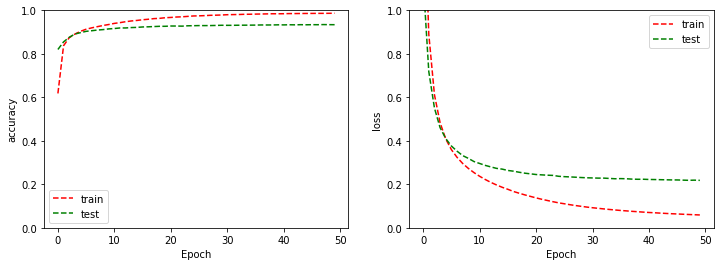

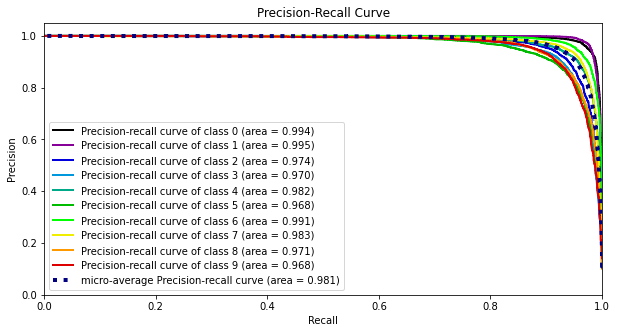

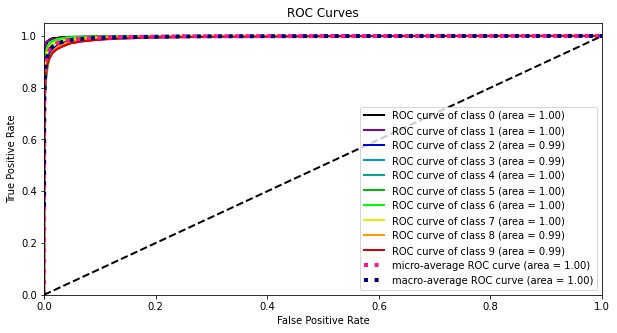

L: 5 N: 1000
Test loss: 0.5379195737566267
Test accuracy: 0.8577714562416077


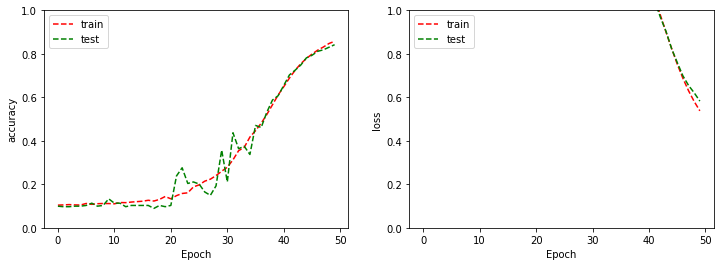

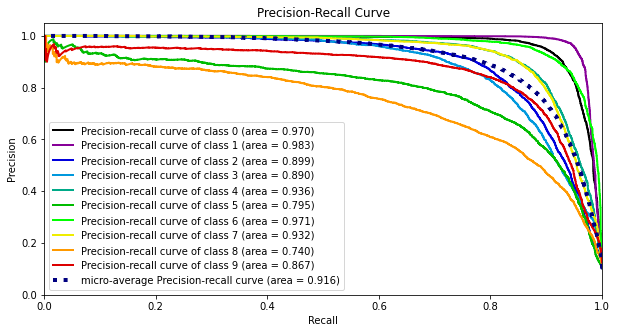

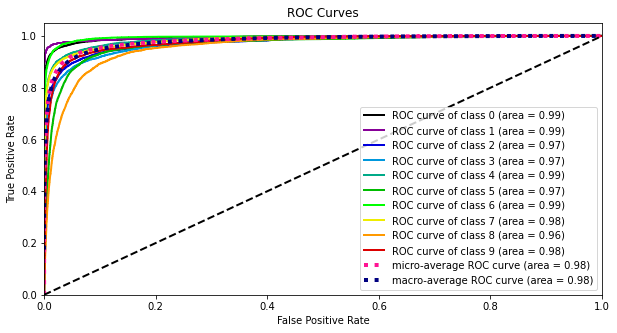

L: 10 N: 1000
Test loss: 2.309851056235177
Test accuracy: 0.10360000282526016


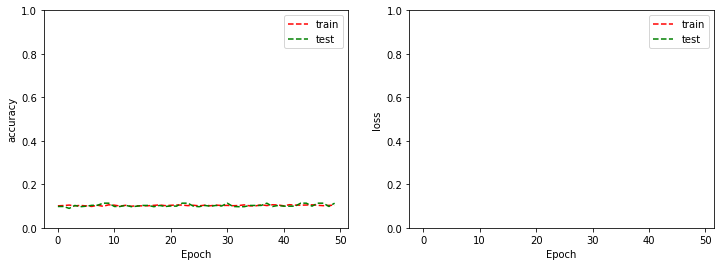

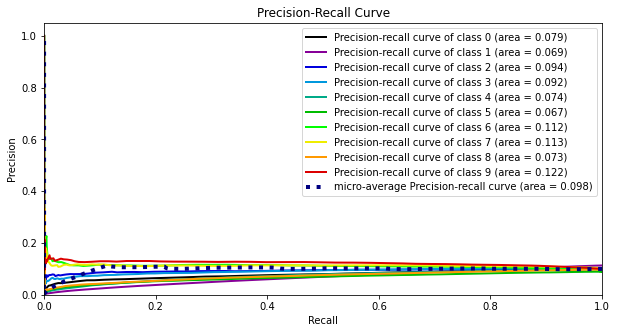

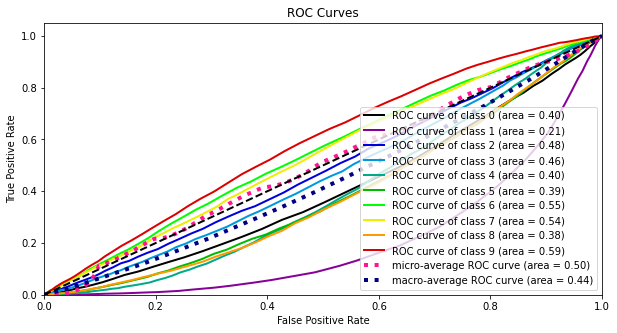


P: 0.4
L: 1 N: 150
Test loss: 0.10173436725139617
Test accuracy: 0.973642885684967


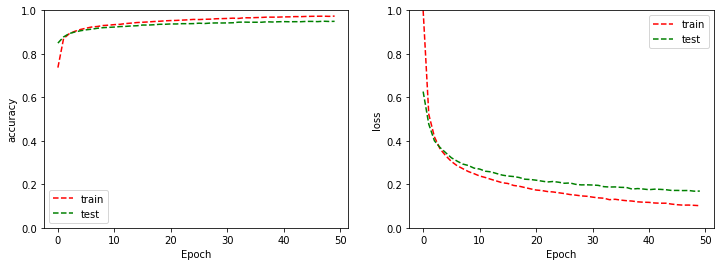

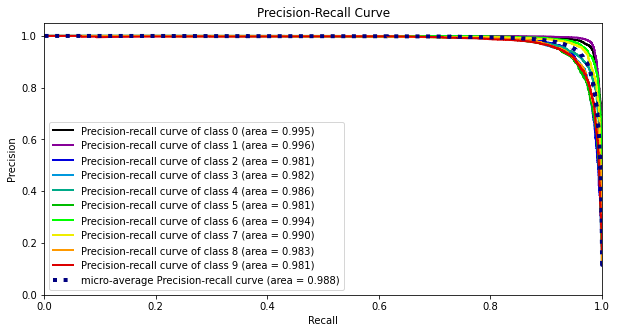

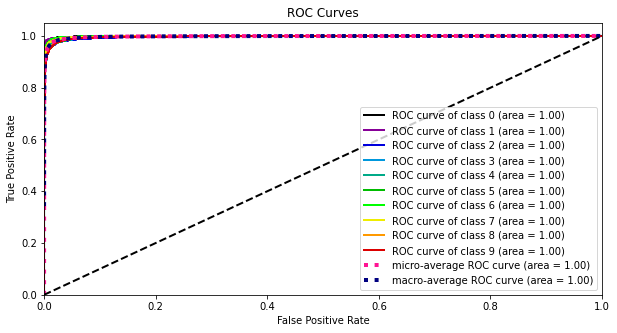

L: 2 N: 150
Test loss: 0.12647933280467988
Test accuracy: 0.9665356874465942


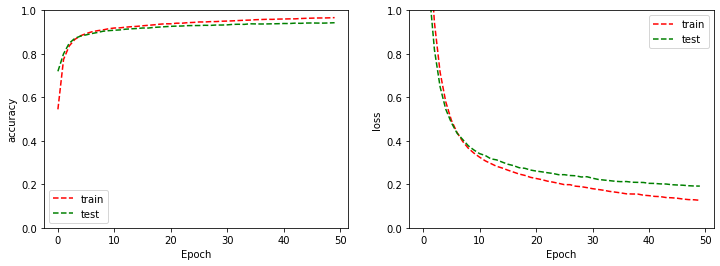

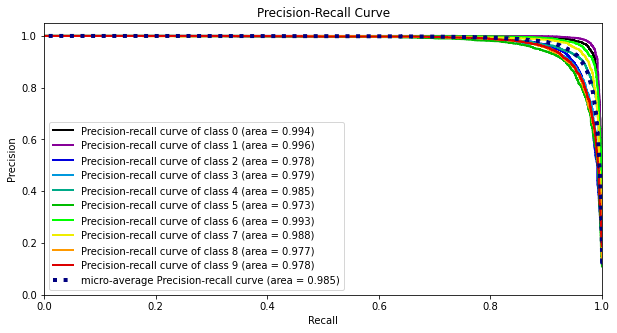

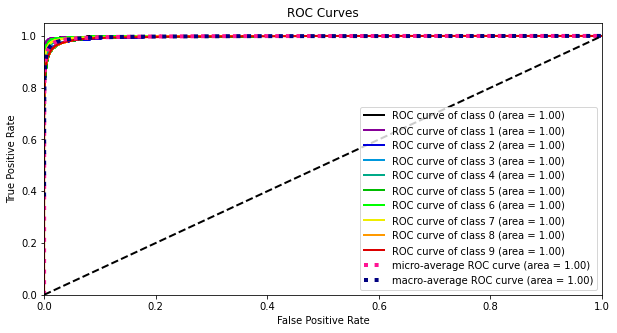

L: 5 N: 150
Test loss: 1.0040669807706561
Test accuracy: 0.687250018119812


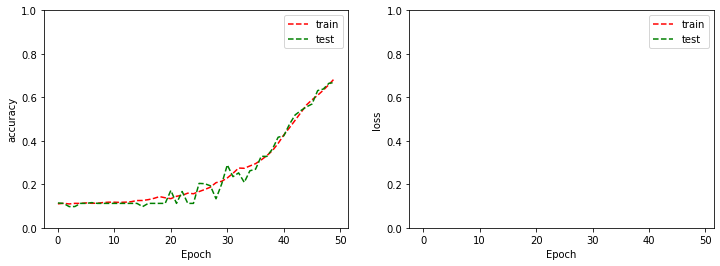

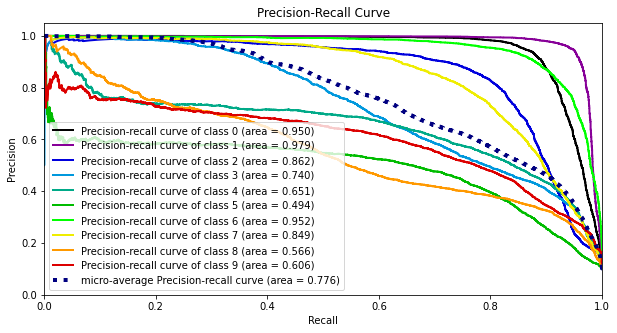

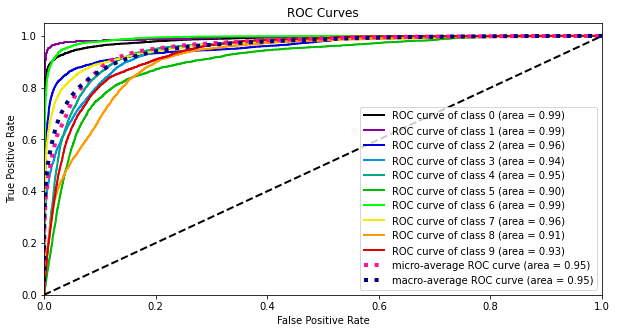

L: 10 N: 150
Test loss: 2.3026664475032264
Test accuracy: 0.10903571546077728


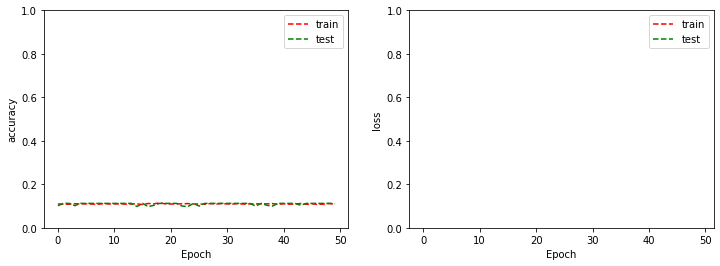

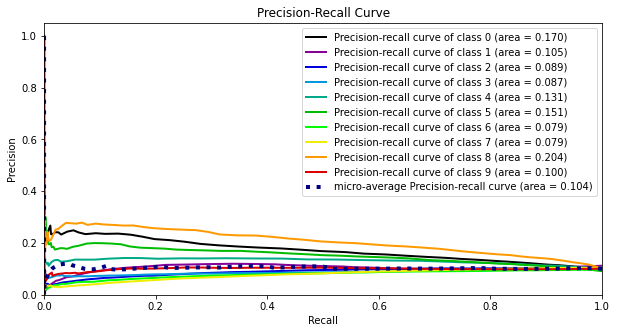

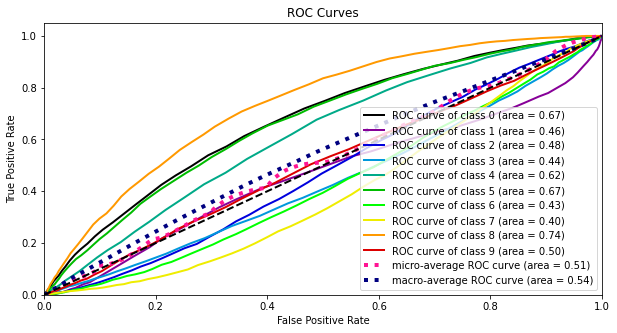

L: 1 N: 1000
Test loss: 0.013614719022597586
Test accuracy: 0.9986071586608887


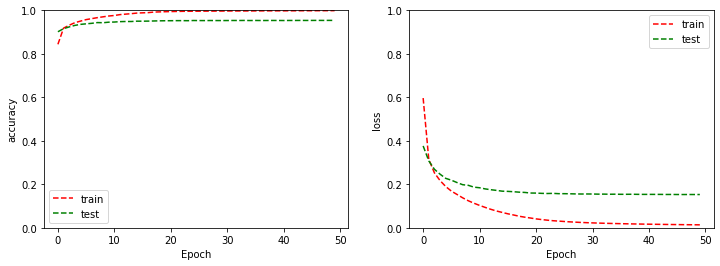

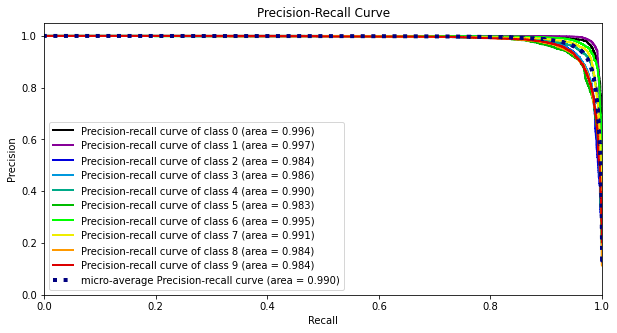

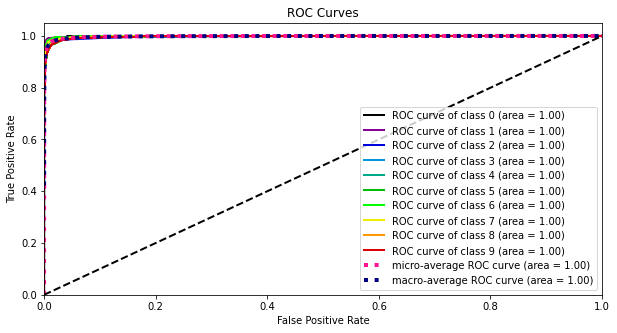

L: 2 N: 1000
Test loss: 0.03903369463660887
Test accuracy: 0.9921785593032837


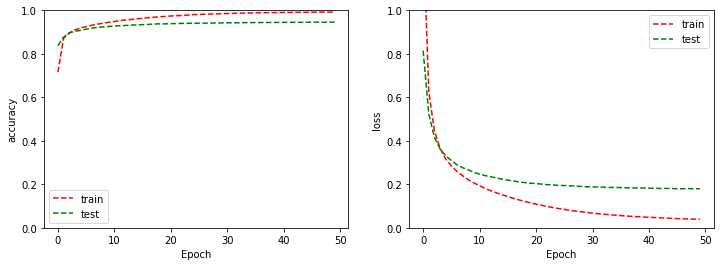

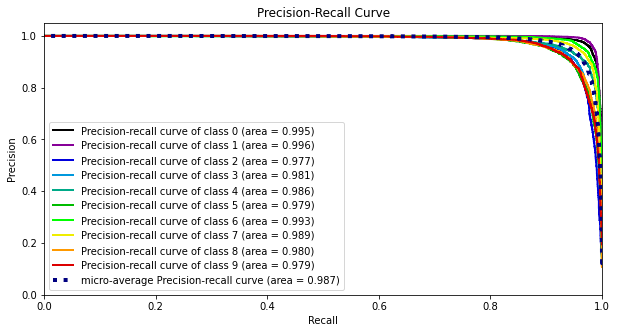

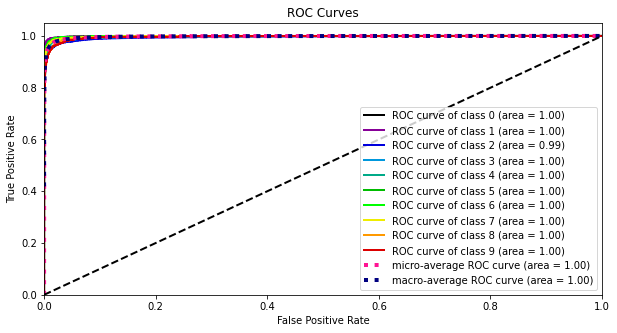

L: 5 N: 1000


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

image_size = 784
x = x.reshape(x.shape[0], image_size)

diff_size(x, y, epochs=50)

In [9]:
epochs(x,y)


E: 5
L: 1 N: 150


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

# FMNIST


P: 0.25
L: 1 N: 150
Test loss: 0.537
Test accuracy: 0.816


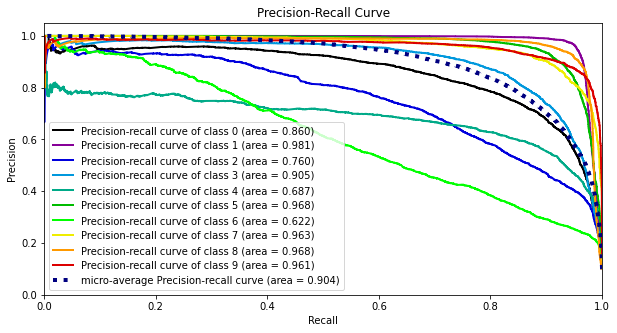

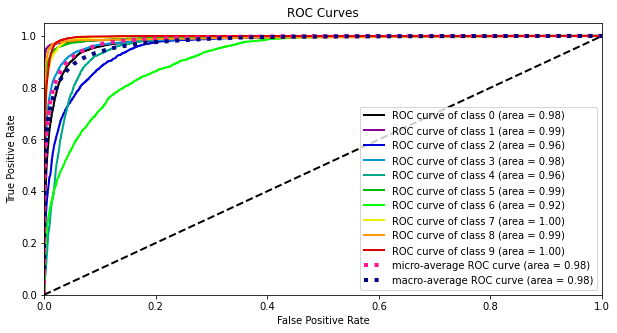

L: 2 N: 150


KeyboardInterrupt: 

In [56]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

image_size = 784
x = x.reshape(x.shape[0], image_size)
diff_size(x, y, epochs=100)

In [ ]:
epochs(x,y)